<a href="https://colab.research.google.com/github/mnilsson8/DSPS_mNilsson/blob/main/HW8/higgsbosonSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import pylab as pl
import os
import json
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_curve, auc, confusion_matrix
from pprint import pprint
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [6]:
#mount your google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Remember tasks are not completed if you do not comment on the results and include captions

# Task 1 : data ingestion

- Download the Higgs boson data from Kaggle (programmatically within the notebook)

see how I did it in the Titanic Trees notebook https://github.com/fedhere/DSPS_FBianco/blob/main/CodeDemos/titanictree.ipynb

find the correct API link here https://www.kaggle.com/c/higgs-boson/data. The command is `!kaggle competitions download......` (you may need to agree to the terms of condition of the higgs boson challenge on the kaggle webpage)


In [7]:
cd /content/gdrive/MyDrive/

/content/gdrive/MyDrive


In [8]:
envs = json.load(open("kaggle/kaggle.json", "r")) # added kaggle/ for me -Ally
os.environ["KAGGLE_USERNAME"] = envs['username']
os.environ["KAGGLE_KEY"] = envs['key']

FileNotFoundError: [Errno 2] No such file or directory: 'kaggle/kaggle.json'

In [9]:
cd dsps

/content/gdrive/MyDrive/dsps


In [ ]:
!mkdir higgsboson

In [10]:
cd higgsboson

/content/gdrive/MyDrive/dsps/higgsboson


In [ ]:
!kaggle competitions download -c higgs-boson

higgs-boson.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
ls

HiggsBosonCompetition_AMSMetric_rev1.py  random_submission.zip  training.csv
higgs-boson.zip                          test.zip               training.zip


In [ ]:
!unzip higgs-boson.zip
!unzip training.zip

Archive:  higgs-boson.zip
replace HiggsBosonCompetition_AMSMetric_rev1.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: nnN
replace random_submission.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [11]:
#use the training dataset and make your own trainng test set later
higgsdata = pd.read_csv("training.csv")

# Task 2: data exploration

In [12]:
higgsdata.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


In [13]:
higgsdata.describe()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,224999.500000,-49.023079,49.239819,81.181982,57.895962,-708.420675,-601.237051,-709.356603,2.373100,18.917332,...,209.797178,0.979176,-348.329567,-399.254314,-399.259788,-692.381204,-709.121609,-709.118631,73.064591,1.646767
std,72168.927986,406.345647,35.344886,40.828691,63.655682,454.480565,657.972302,453.019877,0.782911,22.273494,...,126.499506,0.977426,532.962789,489.338286,489.333883,479.875496,453.384624,453.389017,98.015662,1.875103
min,100000.000000,-999.000000,0.000000,6.329000,0.000000,-999.000000,-999.000000,-999.000000,0.208000,0.000000,...,13.678000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.001502
25%,162499.750000,78.100750,19.241000,59.388750,14.068750,-999.000000,-999.000000,-999.000000,1.810000,2.841000,...,123.017500,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-0.000000,0.018636
50%,224999.500000,105.012000,46.524000,73.752000,38.467500,-999.000000,-999.000000,-999.000000,2.491500,12.315500,...,179.739000,1.000000,38.960000,-1.872000,-2.093000,-999.000000,-999.000000,-999.000000,40.512500,1.156188
75%,287499.250000,130.606250,73.598000,92.259000,79.169000,0.490000,83.446000,-4.593000,2.961000,27.591000,...,263.379250,2.000000,75.349000,0.433000,0.503000,33.703000,-2.457000,-2.275000,109.933750,2.404128
max,349999.000000,1192.026000,690.075000,1349.351000,2834.999000,8.503000,4974.979000,16.690000,5.684000,2834.999000,...,2003.976000,3.000000,1120.573000,4.499000,3.141000,721.456000,4.500000,3.142000,1633.433000,7.822543


do everything else you need to explore the data.... (I can think of 4 more things we have done together)

In [14]:
higgsdata.shape

(250000, 33)

In [15]:
higgsdata.isna().sum()

,0
EventId,0
DER_mass_MMC,0
DER_mass_transverse_met_lep,0
DER_mass_vis,0
DER_pt_h,0
DER_deltaeta_jet_jet,0
DER_mass_jet_jet,0
DER_prodeta_jet_jet,0
DER_deltar_tau_lep,0
DER_pt_tot,0


# Task 3: data preparation


- Read in the trainind data. Extract the target variables. Split the provided training data into a training and a test set.

The last 2 columns are what you want to predict: "weight" and "label".
Remove them from the input data (along any other variable you should remove) and create a separate variable `labels` and a separate variable `weights`, which will be your target variables for, respectively, classification and regression.



 you will use two target variables (you can read more about the data at https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf): find the corresponding columns of the DF and save them as labels and weights respectively

In [16]:
higgsdata = higgsdata.replace(-999,np.nan).dropna()

In [17]:
df = higgsdata.copy()
weights = np.array(df["Weight"].astype(float) )
labels = np.array(df["Label"].astype(str).str.lower())

In [18]:
labels # 's' stands for signal, 'b' for background. You want to find new particles, i.e. "signal"

array(['s', 'b', 's', ..., 's', 's', 'b'], dtype=object)

In [19]:
weights # the weight of the particle

array([0.00265331, 0.08341403, 0.00265331, ..., 0.01863612, 0.0015027 ,
       0.06406078])

use the "training.csv" file, but create your own train/test sets

In [20]:
X = df.drop(columns=["EventId", "Weight", "Label"])

In [21]:
train_x, test_x, train_y, test_y, w_train, w_test = train_test_split(
    X, labels, weights,
    test_size=0.25, random_state=1113, stratify=labels
)
print(X.shape, train_x.shape, test_x.shape,train_y.shape)

(68114, 30) (51085, 30) (17029, 30) (51085,)


In [22]:
train_regress_x, test_regress_x = train_x, test_x
train_regress_y, test_regress_y = w_train, w_test


#Task 4: answer the question (you, not an AI...) why did I not ask you to scale the data like we did in the cluster models?

Because we're using tree classifiers, which split the data along one axis at a time, we don't need to scale the data. The classifier won't be sensitive to differences in scales of the different axes of the data, unlike cluster models which cluster the data along multiple axes at once.



# Task 5: tree-based classifications

Use a Random Forest and a Gradiend Boosted Tree Classifier model to predict the `label` of the particles, i.e. if a particle is `Signal` or `Background`. Get the score of each model on both the training and test set, compare them training and test results and comment on the result for each model (adjust the hyperparameters if you need to)


In [23]:
# Look at parameters used by our current forest
rf = RandomForestClassifier(random_state = 0)
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


In [24]:
#now control some hyperparameters
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=12,
    min_samples_split=8,
    min_samples_leaf=4,
    max_features="sqrt",
    bootstrap=True,
    n_jobs=-1,
    random_state=1113,
    class_weight="balanced_subsample"
)

In [25]:
gbt = GradientBoostingClassifier(
    loss="log_loss",
    learning_rate=0.05,
    max_leaf_nodes=31,
    #max_depth=None,
    #max_iter=600,
    validation_fraction=0.1,
    #early_stopping=True,
    random_state=1113
)

In [26]:
rf.fit(train_x, train_y)


RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       min_samples_leaf=4, min_samples_split=8, n_jobs=-1,
                       random_state=1113)

In [27]:
gbt.fit(train_x, train_y)

GradientBoostingClassifier(learning_rate=0.05, max_leaf_nodes=31,
                           random_state=1113)

# Task 6: model evaluation

calculate the  scores for the training and test sets and compare etc

In [28]:
print(f"the RF scores on the training test is {rf.score(train_x, train_y)}, on the test is {rf.score(test_x,  test_y)}")
print("this indicates our model perform very well, the accuracy is very close.")
print(f"the GBT scores on the training test is {gbt.score(train_x, train_y)}, on the test is {gbt.score(test_x,  test_y)}")
print("this indicates our model perform very well, the accuracy is very close")


the RF scores on the training test is 0.890398355681707, on the test is 0.8412120500322978
this indicates our model perform very well, the accuracy is very close.
the GBT scores on the training test is 0.8405794264461192, on the test is 0.8368077984614481
this indicates our model perform very well, the accuracy is very close


**Comment** is your model performing well? is it .... overfitting?

Both the random forest and the gradient boosted tree classifer model are performing fairly well. The model's score for the training data are similar to the score for the test data, while not being incredibly close to 1.00, which would indicate the model is over fitting. The difference between the training score and the test score for the gradient boosted is just two tenths. However, the accuracy for both models are below 90% for test data.

- Produce a confusion matrix for each model and compare them






In [29]:
# I created this function (mostly copied from sklearn examples).
# You can use it to create the confusion matrix, make sure you pass appropriate label

def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title='', labels=["P", "N"],
                          cmap=plt.cm.bone):
    """
    Plots a confusion matrix.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        normalize (bool, optional): If True, normalize the confusion matrix. Defaults to False.
        title (str, optional): Title of the plot. Defaults to ''.
        labels (list, optional): List of labels for the classes. Defaults to ["P", "N"].
        cmap (matplotlib.colors.Colormap, optional): Colormap for the plot. Defaults to plt.cm.bone.
    """
    if normalize:
          title = title + ' Normalized confusion matrix'
    else:
          title = title + ' Confusion matrix, without normalization'
    # Compute confusion matrix
    if normalize:
      cm = confusion_matrix(y_true, y_pred, normalize='all')
    else:
      cm = confusion_matrix(y_true, y_pred)
    # plot it
    fig, ax = plt.subplots(1, 1)
    fig.subplots_adjust()
    im = ax.imshow(np.rot90(cm), cmap=cmap)
    ax_divider = make_axes_locatable(ax)
    # add an axes to the right of the main axes.
    plt.xticks([0, 1], labels=labels[::-1])

    plt.text(0,1, cm[0,0], ha='center', c="k" if cm[0,0] > 0.2 * cm.sum() else "w")
    plt.text(0,0, cm[0,1], ha='center', c="k" if cm[0,1] > 0.2 * cm.sum() else "w")
    plt.text(1,1, cm[1,0], ha='center', c="k" if cm[1,0] > 0.2 * cm.sum() else "w")
    plt.text(1,0, cm[1,1], ha='center', c="k" if cm[1,1] > 0.2 * cm.sum() else "w")
    plt.ylim(-0.5,1.5)
    plt.yticks([0,1], labels=labels)
    plt.xlabel("prediction")
    plt.ylabel("truth")
    plt.title(title)
    cax = ax_divider.append_axes("right", size="10%", pad="2%")
    cb = plt.colorbar(im, cax=cax)

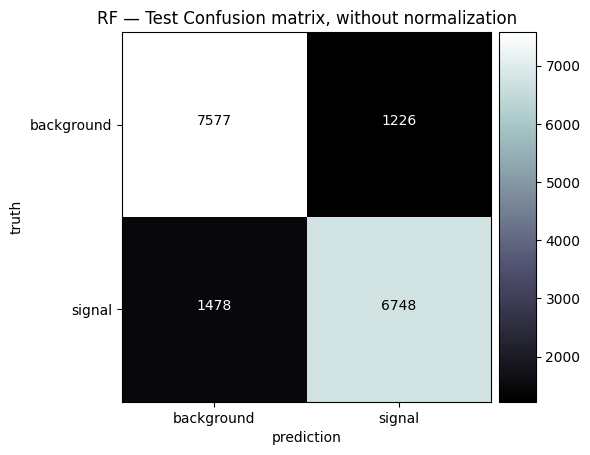

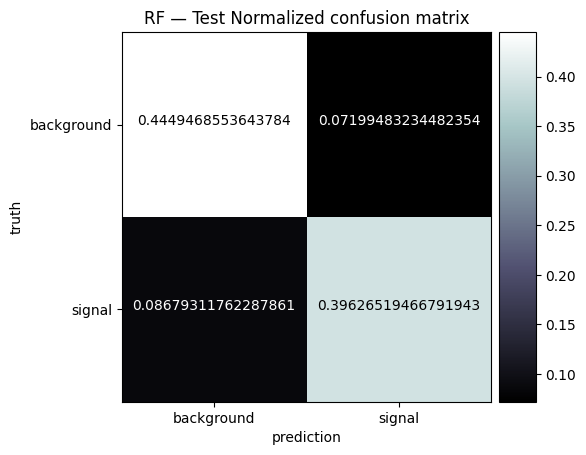

In [30]:

rf_pred_test  = rf.predict(test_x)

plot_confusion_matrix(test_y,  rf_pred_test,  normalize=False,
                      title='RF — Test',  labels=['signal','background'])
plot_confusion_matrix(test_y,  rf_pred_test,  normalize=True,
                      title='RF — Test',  labels=['signal','background'])

**Figure 1:** This figure shows the confusion matrix for the Random Forest model, with the top figure being without normalization and the bottom figure being normalized. The true categories are on the y-axis while the predicted categories for signal or background are on the x-axis. This means the top left and bottom right categories are the correct predictions. From the confusion matrix, it is clear that many of the true signals were classified as background by the Random Forest model and many of the true background events were classified as signals. More true signals were erroneously predicted to be background than background events were predicted to be signals.  

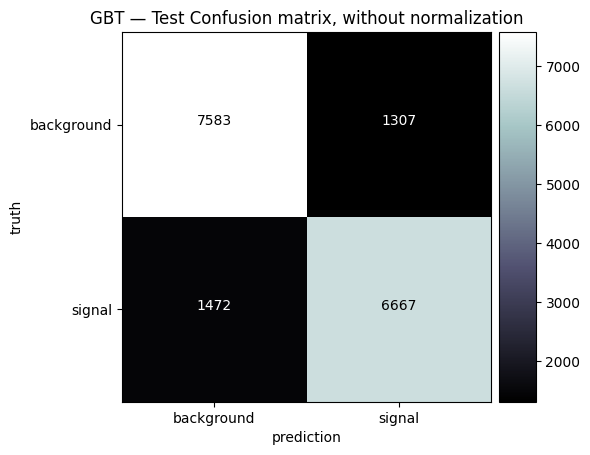

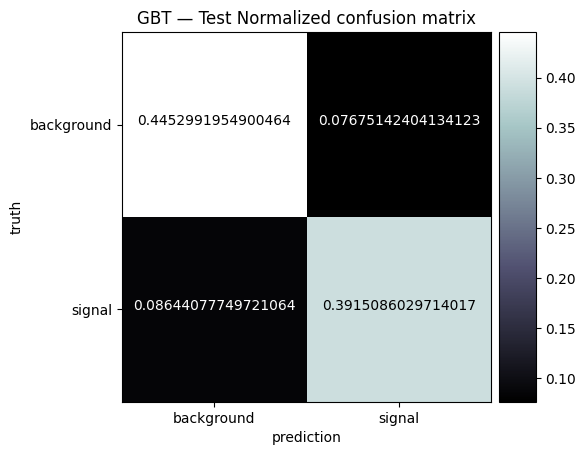

In [31]:
#do the same fo GBT, dont forget your captions!!
gbt_pred_test  = gbt.predict(test_x)
plot_confusion_matrix(test_y,  gbt_pred_test,  normalize=False,
                      title='GBT — Test',  labels=['signal','background'])
plot_confusion_matrix(test_y,  gbt_pred_test,  normalize=True,
                      title='GBT — Test',  labels=['signal','background'])

**Figure 2:** This figure shows the confusion matrix for the Gradient Boosted Tree classifier, with the top figure being without normalization and the bottom figure being normalized. The true categories are on the y-axis while the predicted categories for signal or background are on the x-axis, as in Figure 1. Just as for the Random Forest, many of the true signals were incorrectly classified as background by the Random Forest model. However, fewer signal events were correctly classified by the Gradient Boosted Tree classifier than the Random Forest classifier.

Plot a simple ROC curve for the RF and GBT models  a d describe it in a caption.

In [32]:
#this will be passed to the ROC function
test_y.reshape(-1, 1).flatten() == "s"

array([False, False, False, ..., False,  True, False])

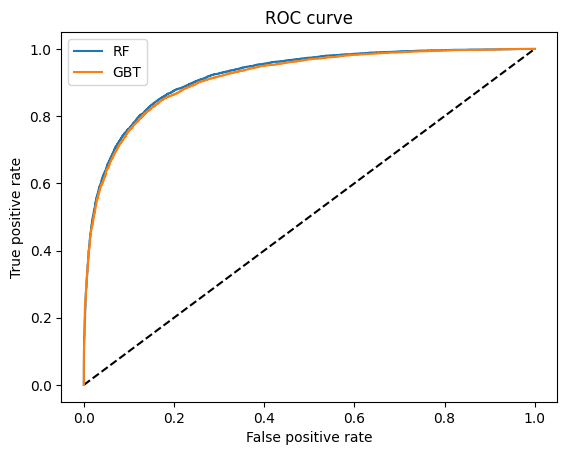

In [33]:
# The random forest model by itself
y_pred_grd_rfcat = rf.predict_proba(test_x)[:, 1]
y_pred_grd_gbtcat = gbt.predict_proba(test_x)[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(test_y.reshape(-1, 1).flatten()=="s", y_pred_grd_rfcat)
fpr_gbt, tpr_gbt, _ = roc_curve(test_y.reshape(-1, 1).flatten()=="s", y_pred_grd_gbtcat)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_gbt, tpr_gbt, label='GBT')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


**Figure 3:** This figure shows the ROC curves for the Random Forest and Gradient Boosted Tree models, with the Random Forest plotted in blue and the Gradient Boosted Tree plotted in orange. The dashed black line indicates a random model, where the false-positive and true-positive rates are equal to each other at every threshold. Both models perform better than random as they are above the dashed line. The Random Forest and Gradient Boosted Tree curves are very similar for low false positive rates and for high false positive rates, but the Random Forest curve is slightly higher, which means the area under the Random Forest curve is also higher and the Random Forest is a better model for the data.

#Task 7 required for 661, EC for 461, tree-based regression


- Use a Random Forest and a Gradiend Boosted Tree Regressor model to predict the weight of the particles. Compare the model performance on training and test sets


In [34]:
rfR = RandomForestRegressor(max_depth=3, random_state=302)
rfR.fit(train_regress_x, train_regress_y)
gbtR = GradientBoostingRegressor(max_depth=3, random_state=302)
gbtR.fit(train_regress_x, train_regress_y)

GradientBoostingRegressor(random_state=302)

 Calculate the L2 and L1 loss functions for the fitted regression models (see slides for the definition) and discuss the results

In [35]:
def L1(y1, y2):
  return np.sum(abs(y1 - y2))

def L2(y1, y2):
  return np.sum((y1-y2)**2)

In [36]:
print(f"L1 RF {L1(test_regress_y,  rfR.predict(test_regress_x)):.2f}, L2 RF {L2(test_regress_y, rfR.predict(test_regress_x)):.2f}")

L1 RF 7072.03, L2 RF 6468.72


In [37]:
print(f"L1 GBT {L1(test_regress_y,  gbtR.predict(test_regress_x)):.2f}, L2 GBT {L2(test_regress_y, gbtR.predict(test_regress_x)):.2f}")

L1 GBT 6003.91, L2 GBT 5137.21


**Discuss!**
The L1 values are higher for both models compared to the L2 functions, which is expected when data sets do not contain outliers.

For the Random Forest, the loss functions L1 and L2 are both greater than the loss functions L1 and L2 for the Gradient Boosted Tree, which suggests that the Gradient Boosted Tree model is a closer fit to the data.

#Task 8: Choose between feature importance and grid optimization (due for both 461 and 661)







# Task 8a: feature importance
Use the "Titanic notebook" as a guide for the feature importance analysis  https://github.com/fedhere/DSPS_FBianco/blob/main/Labs/DSPS_2025_titanictree.ipynb

- For the Random Forest classifier, find the **4 most important features** based on the simple unoptimized model you created earlier on. Use the documentation to find out what they are. We have not talked abotu the physics of this problem at all but the Kaggle challenge description should provide enogh information for you to comment on this result is somewhat superficially.

You can use ```rf.feature_importance_``` on the trained model to extract the relative importance of each feature (a number from 0 to 1) and then choose the features that have the 4 highest numbers (the numpy function ```argsort()``` is helpful here!)

(your features may looks slightly different than mine)

In [38]:
higgsdata = higgsdata.drop(["EventId", "Label", "Weight"], axis=1)

In [39]:

best_features_index_rf = rf.feature_importances_
best_features_index_rf = np.argsort(-best_features_index_rf)


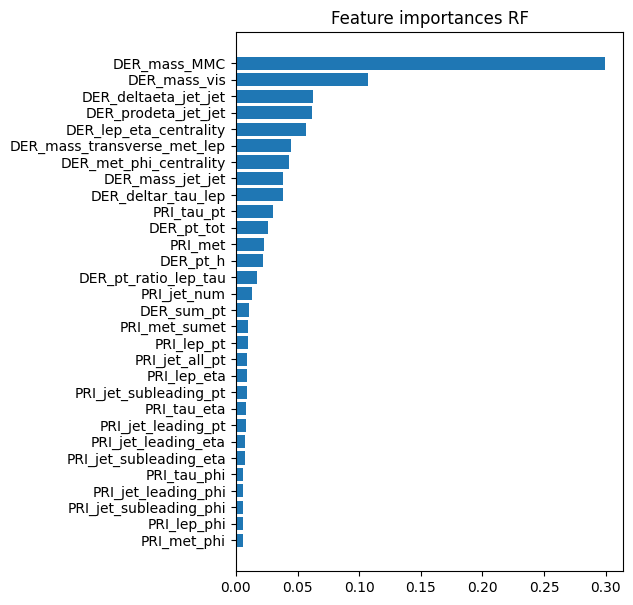

In [40]:
plt.figure(figsize=(5, 7))
plt.title("Feature importances RF")
indices_rf = best_features_index_rf

pl.barh(range(len(indices_rf), 0, -1),
        rf.feature_importances_[indices_rf], align="center")
# pl.xticks(range(rf.feature_importances_.shape[0]), indices)
pl.yticks(range(len(indices_rf), 0, -1),
          labels=higgsdata.columns[indices_rf])

pl.show()

**Figure 4:** This figure plots the feature importance of the Random Forest classifier, with the features along the y-axis sorted so the features with the highest importance are at the top. The four most important features are DER_mass_MMC, DER_mass_vis, DER_deltaeta_jet_jet, and DER_prodeta_jet_jet, which are the mass of the Higgs Boson candidate, the invariant mass of the hadronic tau and lepton, and then the separation of the psuedorapidities of the two jets and the product of the psuedorapidities of the two jets. All of the four most important features are derived features, which are calculated from the primitive values which are directly recorded by the detector.

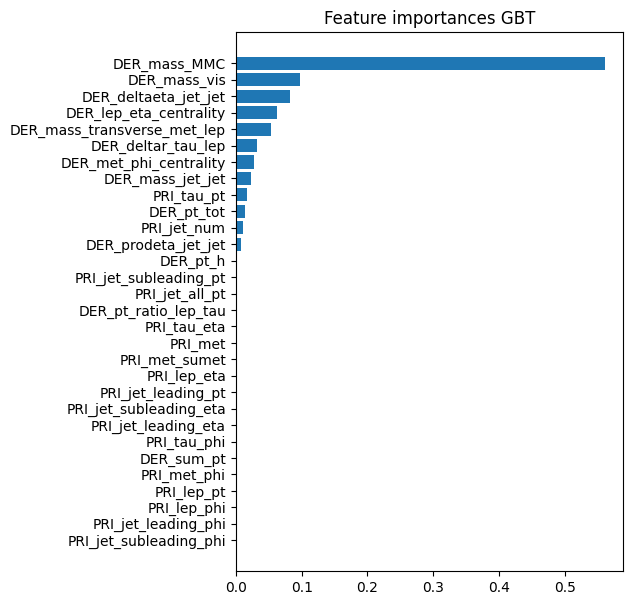

In [41]:
best_features_index_gbt = gbt.feature_importances_
best_features_index_gbt = np.argsort(-best_features_index_gbt)

plt.figure(figsize=(5, 7))
plt.title("Feature importances GBT")
indices_gbt = best_features_index_gbt

pl.barh(range(len(indices_gbt), 0, -1),
        gbt.feature_importances_[indices_gbt], align="center")
pl.yticks(range(len(indices_gbt), 0, -1),
          labels=higgsdata.columns[indices_gbt])

pl.show()

**Figure 5:** This figure plots the feature importances for the Gradient Boosted tree. The same 3 features have the highest feature importance for the Gradient Boosted Tree classifier as the Random Forest classifier, although the fourth most important feature is DER_lep_eta_centrality, which is the centrality of the psuedorapidity of the lepton. The top features also have a greater importance than for the Random Forest classifier. In this figure, several features have no importance for the Gradient Boosted Tree.

# Task 8b: hyperparameters grid search
- Explore the parameter space with the sklearn module ```sklearn.model_selection.RandomizedSearchCV``` *fitting only those 4 features*

Follow this example to set up the parameter search. Set the estimators to 10 and 100, (the number of trees) and the max depth to 3, and 10, and None (let it be unconstrained). Set bootstrap to both True and False. Set the number of features to consider at every split to both "autp" and "sqrt". Use ```pprint``` like I did earlier in this notebook to print the parameters set

**this takes some computational time! so do not start this at the last minute!!**

In [42]:
random_grid = {
    'n_estimators': [10, 100],
    'max_depth': [3, 10, None],
    'bootstrap': [True, False],
    'max_features': ['sqrt', None], # auto no longer seems to be an option
    'random_state': [1]
    }

In [43]:
pprint(random_grid)


{'bootstrap': [True, False],
 'max_depth': [3, 10, None],
 'max_features': ['sqrt', None],
 'n_estimators': [10, 100],
 'random_state': [1]}


 mine and your best features do not necessarily have to be the same because our models may be different (different parameters, different random seed etc)

In [44]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# Random search of parameters, using 3 fold cross validation,
# search across 18 different combinations
random_search = RandomizedSearchCV(estimator = rf, param_distributions=random_grid,
                                   n_iter=18, cv=3, verbose =4, random_state=1)


Note that this may take a long time! It took 1 hour for me to run this. Dont start at the last minute!!

In [45]:
new_x_train = train_x[higgsdata.columns[indices_rf][:4]]
new_x_test = test_x[higgsdata.columns[indices_rf][:4]]
random_search.fit(new_x_train[::5], train_y[::5])
# subselecting every 5th observation to reduce the computational time

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3] END bootstrap=False, max_depth=3, max_features=sqrt, n_estimators=100, random_state=1;, score=0.784 total time=   0.8s
[CV 2/3] END bootstrap=False, max_depth=3, max_features=sqrt, n_estimators=100, random_state=1;, score=0.774 total time=   0.8s
[CV 3/3] END bootstrap=False, max_depth=3, max_features=sqrt, n_estimators=100, random_state=1;, score=0.789 total time=   0.8s
[CV 1/3] END bootstrap=False, max_depth=10, max_features=None, n_estimators=10, random_state=1;, score=0.772 total time=   0.4s
[CV 2/3] END bootstrap=False, max_depth=10, max_features=None, n_estimators=10, random_state=1;, score=0.757 total time=   0.4s
[CV 3/3] END bootstrap=False, max_depth=10, max_features=None, n_estimators=10, random_state=1;, score=0.775 total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=3, max_features=None, n_estimators=100, random_state=1;, score=0.778 total time=   1.2s
[CV 2/3] END bootstrap=True, max_depth=3, ma

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                    max_depth=12,
                                                    min_samples_leaf=4,
                                                    min_samples_split=8,
                                                    n_jobs=-1,
                                                    random_state=1113),
                   n_iter=18,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 10, None],
                                        'max_features': ['sqrt', None],
                                        'n_estimators': [10, 100],
                                        'random_state': [1]},
                   random_state=1, verbose=4)

In [ ]:
random_search.best_estimator_

In [ ]:
for k in random_search.best_params_:
  print(k,random_search.best_params_[k])

In [ ]:
# set best params for new classifier
rf = RandomForestClassifier(**random_search.best_params_)
print(rf.get_params())

In [ ]:
rf.fit(train_x, train_y)

In [ ]:
print("Tuned RF  Parameters: {}".format(random_search.best_params_))
print("Best score is {}".format(rf.score(test_x, test_y)))


In [ ]:
df = pd.DataFrame(random_search.cv_results_) # this shows the result for the given parameters
df

Plot a simple  ROC curve for the RF model with the best parameters found in the previous step. Describe it. Compare it with the GBT model from before

In [ ]:
# The random forest model by itself
y_pred_grd_rfcat = rf.predict_proba(test_x)[:, 1]
y_pred_grd_gbtcat = gbt.predict_proba(test_x)[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(test_y.reshape(-1, 1).flatten()=="s", y_pred_grd_rfcat)
fpr_gbt, tpr_gbt, _ = roc_curve(test_y.reshape(-1, 1).flatten()=="s", y_pred_grd_gbtcat)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_gbt, tpr_gbt, label='GBT')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

**Figure 6:** This figure is a plot of the ROC curves for the Radom Forest classifier with the best parameters and the original Gradient Boosted tree classifier. Compared to Figure 3, the Random Forest curve looks very similar and falls in the same range of the plot. The Random Forest classifier curve is still higher than the Gradient Boosted Tree classifier, but it is closer to the Gradient Boosted Tree curve than the Random Forest classifier in Figure 3. This means the curve is lower despite having selected for the best parameters.